# Figure 5C: results of tfidf approach

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('styles.mplstyle')
from helpers import highlight_highest_scores
from helpers import score_heatmap
from helpers import cm2inch

## Load all scores

In [2]:
scores = []
runs = []
for run in range(5):
    scores_fn = f'../results/run-{run}/tfidf-run-{run}/tfidf-run-{run}-scores.csv'
    if os.path.exists(scores_fn):
        scores.append(pd.read_csv(scores_fn, index_col=0))
        runs.append(run)
    else:
        print(f'Results for run {run} could not be found')

In [3]:
df = (pd.concat(scores, keys=runs, names=['run', 'index'])
        .reset_index()
        .drop('index', axis=1))

In [4]:
means = df.groupby(['subset', 'genre', 'representation', 'segmentation']).mean() * 100
stds  = df.groupby(['subset', 'genre', 'representation', 'segmentation']).std() * 100

## Plot heatmap

In [5]:
SEGMENTATIONS = [
    'neumes',
    'syllables',
    'words',
    '1-mer',
    '2-mer',
    '3-mer',
    '4-mer',
    '5-mer',
    '6-mer',
#     '7-mer',
    '8-mer',
#     '9-mer',
    '10-mer',
#     '11-mer',
    '12-mer',
#     '13-mer',
    '14-mer',
#     '15-mer',
    '16-mer',
    'poisson-3',
    'poisson-5',
    'poisson-7'
]

REPRESENTATIONS = [
    'pitch',
    'interval-dependent',
    'interval-independent',
    'contour-dependent',
    'contour-independent'
]

In [6]:
def reshape_df(df, score, genre, subset, split, 
               index=SEGMENTATIONS, columns=REPRESENTATIONS):
    """Reshape a dataframe with all scores to the slice of interest:
    with representations as columns and segmentations as index, and 
    containing only one type of score as values"""
    return (
        pd.pivot_table(
            df.loc[subset, genre],
            columns='representation',
            index='segmentation', 
            values=f'{split}_{score}'
        ).loc[index, columns]
    )
# reshape_df(means, 'weighted_recall', 'responsory', 'full', 'test')

In [7]:
def show_scores(means, stds, score, genre, subset, split,
                line_length=.55, line_y=.3, lh=.4, tp=.15,
                labels=True, title=True,
                fmt='${mu:.1f}^{{\pm {sigma:.1f}}}$'):
    """Generate a heatmap with scores"""
    subset_means = reshape_df(means, score, genre, subset, split)
    subset_stds = reshape_df(stds, score, genre, subset, split)
    
    # Heatmap
    xticklabels_dict = {
        'pitch': 'pitch',
        'interval-dependent': 'dep.\ninterval',
        'interval-independent': 'indep.\ninterval',
        'contour-dependent': 'dep.\ncontour',
        'contour-independent': 'indep.\ncontour',
    }
    xticklabels = [xticklabels_dict[rep] for rep in REPRESENTATIONS]
    score_heatmap(subset_means, subset_stds,
                  vmin=0, vmax=100, cbar=False,
                  cmap='viridis', fmt=fmt,
                  xticklabels=xticklabels)
    
    # Plot gridlines
    pad = 0
    lw = 1
    plt.plot([1, 1], [0, 100], 'w-', lw=lw)
    plt.plot([3, 3], [0, 100], 'w-', lw=lw)
    plt.plot([0, 100], [3, 3], 'w-', lw=lw)
    plt.plot([0, 100], [14, 14], 'w-', lw=lw)
    
    # Highlight best scores
    highlight_highest_scores(subset_means, axis=0, tol=1, 
                             line_y=line_y, line_length=line_length)
    
    # Axes
    if labels:
        plt.ylabel('segmentation')
        plt.xlabel('representation')
    else:
        plt.ylabel(None)
        plt.xlabel(None)
    plt.yticks(rotation=0)

    # Title
    if title:
        title = f'{genre.title()} {split.title()} {score.replace("weighted_", "").title()}'
        plt.text(0, -tp-2*lh, title, va='bottom', fontweight='bold')
        plt.text(0, -tp-lh, f'Distributional approach on {subset} data', va='bottom')
        plt.text(0, -tp, (
            'Showing $\mathrm{mean}^{\pm\mathrm{std.dev}}$ '
            f'over {len(runs)} runs'
            ), va='bottom', size=5.5, alpha=.5)
    plt.tight_layout()

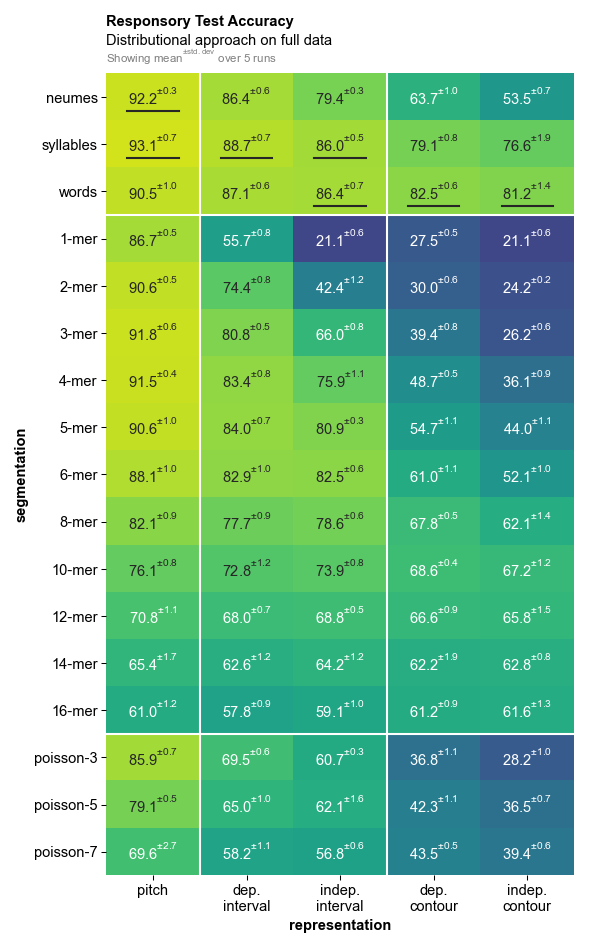

In [8]:
plt.figure(figsize=cm2inch(10, 16), dpi=150)
show_scores(means, stds, 'accuracy', 'responsory', 'full', 'test')

## Generate all plots

In [9]:
for genre in ['responsory', 'antiphon']:
    for subset in ['full', 'subset']:
        for split in ['train', 'test']:
            for score in ['accuracy', 'weighted_f1', 'weighted_precision', 'weighted_recall']:
                plt.ioff() # Turn off interactive plotting
                plt.figure(figsize=cm2inch(10, 16))
                show_scores(means, stds, score, genre, subset, split)
                fig_fn = f'../figures/fig05c-tfidf/fig05c-{genre}-{subset}-{split}-{score}.pdf'
                plt.savefig(fig_fn)
                plt.close()

## Generate plots for final figure

In [10]:
cols = 5
rows = 17
for genre in ['antiphon', 'responsory']:
    plt.ioff() # Turn off interactive plotting
    plt.figure(figsize=cm2inch(2*(cols+1), rows+1), dpi=150)
    show_scores(means, stds, 'weighted_f1', genre, 'full', 'test',
               fmt='${mu:.0f}$', line_length=.2, line_y=.25,
               labels=False, title=False)
    plt.savefig(f'../figures/fig05/fig05-tfidf-{genre}-test-f1.pdf')
    plt.close()